In [1]:
# Import modules
import sys
sys.path.append(r"c:/Users/Raees/Desktop/stuff/NuOscProbExact/src")


from oscprob2nu import *
from globaldefs import *
from hamiltonians2nu import *
from hamiltonians3nu import *
from oscprob3nu import *

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
from scipy.stats import truncnorm
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from scipy.integrate import simpson, quad
from scipy.interpolate import interp1d
import copy as cp
import builtins
import itertools
import scipy.linalg as la
from scipy.linalg import expm
import cmath
import sympy as sp
from scipy.stats import norm
from scipy.stats import chisquare, ks_2samp, pearsonr
from scipy.stats import wasserstein_distance
from scipy.stats import entropy
from scipy.spatial.distance import cdist
import multiprocessing as mp

In [2]:
# Gaussian fit
def gaus(data, amplitude, mean, sigma):
    return amplitude * math.e**((-0.5 * (data - mean)**2) / sigma**2)

def fluctuated_fit(gaus, bin_centers, counts):
    popt, _ = curve_fit(gaus, bin_centers, counts)
    return popt

def param_values2(param=None, sigma_fraction=0.0):
    """
    Returns oscillation parameter values at a given fraction of their uncertainty.

    Args:
        param (str): Name of the parameter.
        sigma_fraction (float): Fraction of the uncertainty (-1 to 1 for ±1σ).

    Returns:
        float: Parameter value adjusted by the given fraction of uncertainty.
    """

    params = {
        'Dm2_21': (7.53e-5, 0.0),  # No uncertainty specified
        's2th12': (0.307, 0.0),  # No uncertainty specified
        's2th13': (0.0210, 0.0011),  # ± 0.0011
        'Dm2_32': (2.41e-3, 0.07e-3),  # ± 0.07e-3
        's2th23': (0.57, 0.03, 0.04),  # +0.03, -0.04
        'd_cp': (0.82 * np.pi, 0.27 * np.pi, 0.87 * np.pi)  # +0.27π, -0.87π
    }

    if param not in params:
        raise ValueError(f"Invalid parameter: {param}")

    central = params[param][0]

    if len(params[param]) == 2:
        uncertainty = params[param][1]

        if param in ['s2th13', 's2th12']:
            return np.sqrt(central + (sigma_fraction * uncertainty))
        else:

            return central + (sigma_fraction * uncertainty)

    elif len(params[param]) == 3:
        pos_unc = params[param][1]
        neg_unc = params[param][2]

        if param in ['s2th23']:
            return np.sqrt(central + sigma_fraction * (pos_unc if sigma_fraction > 0 else neg_unc))
        else:
            return central + sigma_fraction * (pos_unc if sigma_fraction > 0 else neg_unc)

    return central
param_values2('Dm2_32', 0.5)

0.0024449999999999997

In [3]:
# Parameters
bin_centers = np.array([0.375, 0.875, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.125, 2.375, 2.6375, 2.8875, 3.25, 3.75, 4.5])
bin_edges = np.array([0, 0.75, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.25, 2.5, 2.775, 3, 3.5, 4, 5])

# Event counts for muon neutrino beam, muon-to-muon
counts_nd = np.array([5, 42, 72, 96, 120, 148, 170, 192, 208, 214, 212, 204, 170, 112, 66, 36, 16, 5, 1])
counts_fd = np.array([0, 3, 1, 3, 1, 2, 2, 4, 6, 9, 15, 12, 15.8, 10, 7, 9, 3.2, 2.8, 1.8])
adjusted_counts_fd = np.array([ 0.  ,  7.5 ,  1.  ,  3.  ,  1.  ,  2.  ,  2.  ,  4.  ,  6.  ,
        9.  , 15.  , 12.  , 39.5 , 25.  , 19.25, 20.25, 16.  , 14.  ,
       18.  ])
adjusted_counts_nd = np.array([ 37500., 105000.,  72000.,  96000., 120000., 148000., 170000.,
       192000., 208000., 214000., 212000., 204000., 425000., 280000.,
       181500.,  81000.,  80000.,  25000.,  10000.])

# Event counts for electron neutrio beam, muon-to-electron
counts_nd_e = np.array([0.01, 0.5, 2.4, 4.6, 4, 2.6, 1.8 ,1.4, 1.2])
adjusted_counts_nd_e = np.array([10, 500, 2400, 4600, 400, 2600, 1800, 1400, 1200])
counts_fd_e = np.array([5 ,21, 18, 4, 1, 1])
bin_centers_e = np.array([0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25])
bin_edges_e = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5])

length_nd = 1 # [km]
length_fd = 810 # [km]

bin_widths = bin_edges[1:] - bin_edges[:-1]

# Event counts for antineutrino beam
anti_counts_nd = np.array([2.5, 20, 38.75, 45 ,67.5, 70, 85, 97.5, 107.5, 113.75, 115, 111.25, 95, 62.5, 37.5, 20, 10, 2.5, 0])
anti_counts_fd = np.array([0.25, 2, 1, 2, 0, 2, 3, 0, 0, 8, 3, 7, 4.4, 6, 2.4, 2, 2.4, 1.25, 1.75])
anti_counts_nd_e = np.array([0, 0.25, 1.3, 2.5, 2.52, 1.9, 1.35, 1.15, 0.95]) # The High CNN one, cause it might be better?
anti_counts_fd_e = np.array([1, 8, 5, 3, 1, 1])

adjusted_anti_counts_nd_e = np.array([0, 250, 1300, 2500, 2520, 1900, 1350, 1150, 950])
adjusted_anti_counts_nd = anti_counts_nd * (bin_widths / 0.1) * 1000
adjusted_anti_counts_fd = anti_counts_fd * (bin_widths / 0.1)

initial_guess = [140, 2, 0.5]

popt_nd, _ = curve_fit(gaus, bin_centers, counts_nd, p0=initial_guess)
print(f"Fitted parameters for observed the unoscillated ND events: Amplitude = {popt_nd[0]}, Mean = {popt_nd[1]}, Sigma = {popt_nd[2]}")


popt_nd_e, _ = curve_fit(gaus, bin_centers_e, counts_nd_e, p0=[5,2, 0.5])
print(f"Fitted parameters for observed the unoscillated ND electon events: Amplitude = {popt_nd_e[0]}, Mean = {popt_nd_e[1]}, Sigma = {popt_nd_e[2]}")

popt_anti_nd, _ = curve_fit(gaus, bin_centers, anti_counts_nd, p0=[120,2,0.5])
print(f"Fitted parameters for observed the unoscillated antineutrino ND events: Amplitude = {popt_anti_nd[0]}, Mean = {popt_anti_nd[1]}, Sigma = {popt_anti_nd[2]}")


popt_anti_nd_e, _ = curve_fit(gaus, bin_centers_e, anti_counts_nd_e, p0=[5,2,0.5])
print(f"Fitted parameters for observed the unoscillated antineutrino ND electron events: Amplitude = {popt_anti_nd_e[0]}, Mean = {popt_anti_nd_e[1]}, Sigma = {popt_anti_nd_e[2]}")

x = np.arange(0.01,5,0.01)

Fitted parameters for observed the unoscillated ND events: Amplitude = 212.76692701207105, Mean = 1.8044188236034169, Sigma = 0.525448417032163
Fitted parameters for observed the unoscillated ND electon events: Amplitude = 4.218662147714044, Mean = 2.1341687610051183, Sigma = 0.8475810459857663
Fitted parameters for observed the unoscillated antineutrino ND events: Amplitude = 113.1060196955553, Mean = 1.8355298839724858, Sigma = 0.5285564990530245
Fitted parameters for observed the unoscillated antineutrino ND electron events: Amplitude = 2.4344413635605364, Mean = 2.356842604598921, Sigma = 0.9997075655274238


In [4]:
def osc_prob_mm_3nu(s2th23, s2th13, d_cp, Dm2_32):

    energy = x * 1e9
    length_scaled_nd = 1 * CONV_KM_TO_INV_EV
    length_scaled_fd = 810 * CONV_KM_TO_INV_EV

    cases = ['vacuum', 'matter']
    types = ['neutrino', 'antineutrino']

    all_counts = {}
        

    for case in cases:
        for particle_type in types:

            if particle_type  == 'neutrino':

                hamiltonian = hamiltonian_3nu_vacuum_energy_independent(param_values2('s2th12',0), s2th23,
                                                                    s2th13, d_cp,
                                                                    param_values2('Dm2_21', 0), Dm2_32
                                                                    )
            else:
                hamiltonian = hamiltonian_3nu_vacuum_energy_independent(param_values2('s2th12',0), s2th23,
                                                                    s2th13, d_cp,
                                                                    param_values2('Dm2_21', 0), Dm2_32
                                                                    )
                hamiltonian = np.conj(hamiltonian)

            if case == 'vacuum':
                def calculate_hamiltonian(h, e): return h / e
            elif case == 'matter' and particle_type  == 'neutrino':  
                def calculate_hamiltonian(h, e): return hamiltonian_3nu_matter(h, e, VCC_EARTH_CRUST)
            elif case == 'matter' and particle_type  == 'antineutrino':  
                def calculate_hamiltonian(h, e): return hamiltonian_3nu_matter(h, e, -VCC_EARTH_CRUST)

            prob_nd = np.array([
                probabilities_3nu(calculate_hamiltonian(hamiltonian, e), length_scaled_nd)
                for e in energy
            ])

            prob_fd = np.array([
                probabilities_3nu(calculate_hamiltonian(hamiltonian, e), length_scaled_fd)
                for e in energy
            ])

            prob_mm_nd = prob_nd[:,4]
            prob_mm_fd = prob_fd[:,4]

            if particle_type == 'neutrino':
                popt_mm, bin_edges_mm = popt_nd, bin_edges
            else:
                popt_mm, bin_edges_mm = popt_anti_nd, bin_edges

            gaus_mm_fd = prob_mm_fd * gaus(x, *popt_mm)
            gaus_mm_nd = prob_mm_nd * gaus(x, *popt_mm)

            gf_mm_fd = interp1d(x, gaus_mm_fd, fill_value=0, bounds_error=False)
            gf_mm_nd = interp1d(x, gaus_mm_nd, fill_value=0, bounds_error=False)

            areas_mm_nd = np.array([quad(gf_mm_nd, bin_edges_mm[i], bin_edges_mm[i+1])[0] for i in range(len(bin_edges_mm) - 1)])
            areas_mm_fd = np.array([quad(gf_mm_fd, bin_edges_mm[i], bin_edges_mm[i+1])[0] for i in range(len(bin_edges_mm) - 1)])

            bin_widths_mm = np.diff(bin_edges_mm)
            if particle_type == 'neutrino':
                counts_mm_nd = areas_mm_nd / bin_widths_mm
                counts_mm_fd = (areas_mm_fd / bin_widths_mm) * (np.sum(adjusted_counts_fd) / np.sum(adjusted_counts_nd)) * (1000 * np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd))
            else:
                counts_mm_nd = areas_mm_nd / bin_widths_mm
                counts_mm_fd = (areas_mm_fd / bin_widths_mm) * (np.sum(adjusted_anti_counts_fd) / np.sum(adjusted_anti_counts_nd)) * (1000 * np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd))

            all_counts[(particle_type, case)] = (counts_mm_nd, counts_mm_fd)

    return all_counts

In [5]:
from joblib import Parallel, delayed

def evaluate_param_set_vac(s2th23, s2th13, d_cp, Dm2_32, input):
    results = osc_prob_mm_3nu(s2th23, s2th13, d_cp, Dm2_32)

    if input == 'counts_fd':
        real_counts = counts_fd
        _, counts = results[('neutrino', 'vacuum')]
    elif input == 'anti_counts_fd':
        real_counts = anti_counts_fd
        _, counts = results[('antineutrino', 'vacuum')]
    else:
        raise ValueError("Invalid input type")

    emd = wasserstein_distance(real_counts, counts)

    epsilon = 1e-15
    chi_squared = np.sum(((real_counts - counts) ** 2) / (real_counts + counts + epsilon))

    hist1_norm = real_counts / real_counts.sum()
    hist2_norm = counts / counts.sum()
    kl_divergence = entropy(hist1_norm, hist2_norm)

    average_distance = np.mean([emd, chi_squared, kl_divergence])

    return {
        's2th23': s2th23,
        's2th13': s2th13,
        'd_cp': d_cp,
        'Dm2_32': Dm2_32,
        'emd': emd,
        'chi_squared': chi_squared,
        'kl_divergence': kl_divergence,
        'average_distance': average_distance
    }

def find_best_fit_params_3nu_vac(input):
    s2th23_vals = np.linspace(0.55, 0.85, 10)
    s2th13_vals = np.linspace(0.035, 0.05, 10)
    d_cp_vals = np.linspace(0, np.pi, 5)
    Dm2_32_vals = np.linspace(1.9e-3, 2.3e-3, 10)

    s2th13_vals = np.sqrt(s2th13_vals)
    s2th23_vals = np.sqrt(s2th23_vals)

    param_grid = list(itertools.product(s2th23_vals, s2th13_vals, d_cp_vals, Dm2_32_vals))

    results_list = Parallel(n_jobs=-1, backend='loky')(
        delayed(evaluate_param_set_vac)(s2th23, s2th13, d_cp, Dm2_32, input)
        for s2th23, s2th13, d_cp, Dm2_32 in param_grid
    )

    results_df = pd.DataFrame(results_list)

    best_row = results_df.loc[results_df['average_distance'].idxmin()]
    best_params = tuple(best_row[['s2th23', 's2th13', 'd_cp', 'Dm2_32']])

    best_emd_row = results_df.loc[results_df['emd'].idxmin()]
    best_params_emd = tuple(best_emd_row[['s2th23', 's2th13', 'd_cp', 'Dm2_32']])

    best_chi2_row = results_df.loc[results_df['chi_squared'].idxmin()]
    best_params_chi2 = tuple(best_chi2_row[['s2th23', 's2th13', 'd_cp', 'Dm2_32']])

    best_kld_row = results_df.loc[results_df['kl_divergence'].idxmin()]
    best_params_kld = tuple(best_kld_row[['s2th23', 's2th13', 'd_cp', 'Dm2_32']])

    return best_params, best_params_emd, best_params_chi2, best_params_kld, results_df

#===========================================================================================================================

def evaluate_param_set_mat(s2th23, s2th13, d_cp, Dm2_32, input):
    results = osc_prob_mm_3nu(s2th23, s2th13, d_cp, Dm2_32)

    if input == 'counts_fd':
        real_counts = counts_fd
        _, counts = results[('neutrino', 'vacuum')]
    elif input == 'anti_counts_fd':
        real_counts = anti_counts_fd
        _, counts = results[('antineutrino', 'vacuum')]
    else:
        raise ValueError("Invalid input type")

    emd = wasserstein_distance(real_counts, counts)

    epsilon = 1e-15
    chi_squared = np.sum(((real_counts - counts) ** 2) / (real_counts + counts + epsilon))

    hist1_norm = real_counts / real_counts.sum()
    hist2_norm = counts / counts.sum()
    kl_divergence = entropy(hist1_norm, hist2_norm)

    average_distance = np.mean([emd, chi_squared, kl_divergence])

    return {
        's2th23': s2th23,
        's2th13': s2th13,
        'd_cp': d_cp,
        'Dm2_32': Dm2_32,
        'emd': emd,
        'chi_squared': chi_squared,
        'kl_divergence': kl_divergence,
        'average_distance': average_distance
    }

def find_best_fit_params_3nu_mat(input):
    s2th23_vals = np.linspace(0.55, 0.85, 10)
    s2th13_vals = np.linspace(0.035, 0.05, 10)
    d_cp_vals = np.linspace(0, np.pi, 5)
    Dm2_32_vals = np.linspace(1.9e-3, 2.3e-3, 10)

    s2th13_vals = np.sqrt(s2th13_vals)
    s2th23_vals = np.sqrt(s2th23_vals)

    param_grid = list(itertools.product(s2th23_vals, s2th13_vals, d_cp_vals, Dm2_32_vals))

    results_list = Parallel(n_jobs=-1, backend='loky')(
        delayed(evaluate_param_set_mat)(s2th23, s2th13, d_cp, Dm2_32, input)
        for s2th23, s2th13, d_cp, Dm2_32 in param_grid
    )

    results_df = pd.DataFrame(results_list)

    best_row = results_df.loc[results_df['average_distance'].idxmin()]
    best_params = tuple(best_row[['s2th23', 's2th13', 'd_cp', 'Dm2_32']])

    best_emd_row = results_df.loc[results_df['emd'].idxmin()]
    best_params_emd = tuple(best_emd_row[['s2th23', 's2th13', 'd_cp', 'Dm2_32']])

    best_chi2_row = results_df.loc[results_df['chi_squared'].idxmin()]
    best_params_chi2 = tuple(best_chi2_row[['s2th23', 's2th13', 'd_cp', 'Dm2_32']])

    best_kld_row = results_df.loc[results_df['kl_divergence'].idxmin()]
    best_params_kld = tuple(best_kld_row[['s2th23', 's2th13', 'd_cp', 'Dm2_32']])

    return best_params, best_params_emd, best_params_chi2, best_params_kld, results_df

In [21]:
best_params_anti_counts_fd_mat, best_params_emd_anti_counts_fd_mat, best_params_chi2_anti_counts_fd_mat, best_params_kld_anti_counts_fd_mat, results_df_anti_counts_fd_mat  = find_best_fit_params_3nu_mat('anti_counts_fd')
print("Best overall parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_anti_counts_fd_mat)
print("Best EMD parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_emd_anti_counts_fd_mat)
print("Best CHI2 parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_chi2_anti_counts_fd_mat)
print("Best KL_D parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_kld_anti_counts_fd_mat)
print('\n')
best_params_anti_counts_fd_vac, best_params_emd_anti_counts_fd_vac, best_params_chi2_anti_counts_fd_vac, best_params_kld_anti_counts_fd_vac, results_df_anti_counts_fd_vac  = find_best_fit_params_3nu_vac('anti_counts_fd')
print("Best overall parameters for neutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_anti_counts_fd_vac)
print("Best EMD parameters for neutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_emd_anti_counts_fd_vac)
print("Best CHI2 parameters for neutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_chi2_anti_counts_fd_vac)
print("Best KL_D parameters for neutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_kld_anti_counts_fd_vac)

Best overall parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32): (0.806225774829855, 0.22360679774997896, 0.0, 0.0021222222222222224)
Best EMD parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32): (0.806225774829855, 0.22360679774997896, 2.356194490192345, 0.002211111111111111)
Best CHI2 parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32): (0.806225774829855, 0.22360679774997896, 0.7853981633974483, 0.0021222222222222224)
Best KL_D parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32): (0.806225774829855, 0.2, 0.7853981633974483, 0.0021222222222222224)


Best overall parameters for neutrinos (s2th23, s2th13, d_cp, Dm2_32): (0.806225774829855, 0.22360679774997896, 0.0, 0.0021222222222222224)
Best EMD parameters for neutrinos (s2th23, s2th13, d_cp, Dm2_32): (0.806225774829855, 0.22360679774997896, 2.356194490192345, 0.002211111111111111)
Best CHI2 parameters for neutrinos (s2th23, s2th13, d_cp, Dm2_32): (0.806225774829855, 0.22360679774997896, 0.785398163397

In [22]:
best_params_counts_fd_mat, best_params_emd_counts_fd_mat, best_params_chi2_counts_fd_mat, best_params_kld_counts_fd_mat, results_df_ounts_fd_mat  = find_best_fit_params_3nu_mat('counts_fd')
print("Best overall parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_counts_fd_mat)
print("Best EMD parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_emd_counts_fd_mat)
print("Best CHI2 parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_chi2_counts_fd_mat)
print("Best KL_D parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_kld_counts_fd_mat)
print('\n')
best_params_counts_fd_vac, best_params_emd_counts_fd_vac, best_params_chi2_counts_fd_vac, best_params_kld_counts_fd_vac, results_df_counts_fd_vac  = find_best_fit_params_3nu_vac('counts_fd')
print("Best overall parameters for neutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_counts_fd_vac)
print("Best EMD parameters for neutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_emd_counts_fd_vac)
print("Best CHI2 parameters for neutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_chi2_counts_fd_vac)
print("Best KL_D parameters for neutrinos (s2th23, s2th13, d_cp, Dm2_32):", best_params_kld_counts_fd_vac)

Best overall parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32): (0.7852812659593165, 0.22360679774997896, 1.5707963267948966, 0.002033333333333333)
Best EMD parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32): (0.7852812659593165, 0.22360679774997896, 1.5707963267948966, 0.002211111111111111)
Best CHI2 parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32): (0.7852812659593165, 0.22360679774997896, 0.0, 0.001988888888888889)
Best KL_D parameters for antineutrinos (s2th23, s2th13, d_cp, Dm2_32): (0.7852812659593165, 0.22360679774997896, 1.5707963267948966, 0.002033333333333333)


Best overall parameters for neutrinos (s2th23, s2th13, d_cp, Dm2_32): (0.7852812659593165, 0.22360679774997896, 1.5707963267948966, 0.002033333333333333)
Best EMD parameters for neutrinos (s2th23, s2th13, d_cp, Dm2_32): (0.7852812659593165, 0.22360679774997896, 1.5707963267948966, 0.002211111111111111)
Best CHI2 parameters for neutrinos (s2th23, s2th13, d_cp, Dm2_32): (0.7852812659593165,

In [42]:
def compute_uncertainties(results_df):
    best_score = results_df['average_distance'].min()
    score_threshold = (0.1*best_score) + best_score
    
    # Filter: Keep rows where average_distance is within threshold of best
    close_fits = results_df[np.abs(results_df['average_distance'] - best_score) <= score_threshold]
    close_fits = results_df[results_df['average_distance'] <= score_threshold]

    # Compute uncertainties (standard deviation)
    uncertainties = {
        's2th23_mean': close_fits['s2th23'].mean(),
        's2th23_std': close_fits['s2th23'].std(),
        's2th13_mean': close_fits['s2th13'].mean(),
        's2th13_std': close_fits['s2th13'].std(),
        'd_cp_mean': close_fits['d_cp'].mean(),
        'd_cp_std': close_fits['d_cp'].std(),
        'Dm2_32_mean': close_fits['Dm2_32'].mean(),
        'Dm2_32_std': close_fits['Dm2_32'].std(),
        # Distance metric means and stds
        'emd_mean': close_fits['emd'].mean(),
        'emd_std': close_fits['emd'].std(),
        'chi_squared_mean': close_fits['chi_squared'].mean(),
        'chi_squared_std': close_fits['chi_squared'].std(),
        'kl_divergence_mean': close_fits['kl_divergence'].mean(),
        'kl_divergence_std': close_fits['kl_divergence'].std(),
        'average_distance_mean': close_fits['average_distance'].mean(),
        'average_distance_std': close_fits['average_distance'].std(),

        # Number of points
        'n_points': len(close_fits)
    }

    return uncertainties

In [44]:
best_score = results_df_anti_counts_fd_mat['average_distance'].min()
for pct in [0.05, 0.1, 0.15]:
    print(f"Threshold = {pct*100}%")
    score_thresh = best_score * (1 + pct)
    close_fits = results_df_anti_counts_fd_mat[results_df_anti_counts_fd_mat['average_distance'] <= score_thresh]
    print(f"Points in region: {len(close_fits)}")
    print("s2th23 std:", close_fits['s2th23'].std())
    print("s2th13 std:", close_fits['s2th13'].std())
    print("d_cp std:", close_fits['d_cp'].std())
    print("Dm2_32 std:", close_fits['Dm2_32'].std())
    print("----")

Threshold = 5.0%
Points in region: 810
s2th23 std: 0.0194907708153456
s2th13 std: 0.011508370251282419
d_cp std: 1.1143995860051326
Dm2_32 std: 6.438531154854094e-05
----
Threshold = 10.0%
Points in region: 1702
s2th23 std: 0.028520224216733895
s2th13 std: 0.011704450506361829
d_cp std: 1.106464751046077
Dm2_32 std: 9.221623472397948e-05
----
Threshold = 15.0%
Points in region: 2563
s2th23 std: 0.033643084770211114
s2th13 std: 0.011647464493464323
d_cp std: 1.1085659313957756
Dm2_32 std: 0.00011353498535712696
----


In [45]:
uncertainty_anti_fd_mat = compute_uncertainties(results_df_anti_counts_fd_mat)
for k, v in uncertainty_anti_fd_mat.items():
    print(f"{k}: {v:.5f}")
print('\n')
uncertainty_anti_fd_vac = compute_uncertainties(results_df_anti_counts_fd_vac)
for k, v in uncertainty_anti_fd_vac.items():
    print(f"{k}: {v:.5f}")

s2th23_mean: 0.79296
s2th23_std: 0.02852
s2th13_mean: 0.20617
s2th13_std: 0.01170
d_cp_mean: 1.56803
d_cp_std: 1.10646
Dm2_32_mean: 0.00212
Dm2_32_std: 0.00009
emd_mean: 0.68078
emd_std: 0.08751
chi_squared_mean: 17.20552
chi_squared_std: 0.45358
kl_divergence_mean: 0.61098
kl_divergence_std: 0.02965
average_distance_mean: 6.16576
average_distance_std: 0.17071
n_points: 1702.00000


s2th23_mean: 0.79296
s2th23_std: 0.02852
s2th13_mean: 0.20617
s2th13_std: 0.01170
d_cp_mean: 1.56803
d_cp_std: 1.10646
Dm2_32_mean: 0.00212
Dm2_32_std: 0.00009
emd_mean: 0.68078
emd_std: 0.08751
chi_squared_mean: 17.20552
chi_squared_std: 0.45358
kl_divergence_mean: 0.61098
kl_divergence_std: 0.02965
average_distance_mean: 6.16576
average_distance_std: 0.17071
n_points: 1702.00000


In [46]:
uncertainty_fd_mat = compute_uncertainties(results_df_ounts_fd_mat)
for k, v in uncertainty_fd_mat.items():
    print(f"{k}: {v:.5f}")
print('\n')
uncertainty_fd_vac = compute_uncertainties(results_df_counts_fd_vac)
for k, v in uncertainty_fd_vac.items():
    print(f"{k}: {v:.5f}")

s2th23_mean: 0.78291
s2th23_std: 0.01594
s2th13_mean: 0.20624
s2th13_std: 0.01156
d_cp_mean: 1.58601
d_cp_std: 1.10915
Dm2_32_mean: 0.00202
Dm2_32_std: 0.00005
emd_mean: 0.98199
emd_std: 0.17559
chi_squared_mean: 14.29859
chi_squared_std: 0.44777
kl_divergence_mean: 0.27340
kl_divergence_std: 0.00401
average_distance_mean: 5.18466
average_distance_std: 0.14464
n_points: 568.00000


s2th23_mean: 0.78291
s2th23_std: 0.01594
s2th13_mean: 0.20624
s2th13_std: 0.01156
d_cp_mean: 1.58601
d_cp_std: 1.10915
Dm2_32_mean: 0.00202
Dm2_32_std: 0.00005
emd_mean: 0.98199
emd_std: 0.17559
chi_squared_mean: 14.29859
chi_squared_std: 0.44777
kl_divergence_mean: 0.27340
kl_divergence_std: 0.00401
average_distance_mean: 5.18466
average_distance_std: 0.14464
n_points: 568.00000


In [65]:
def propagate_square(value, uncertainty):
    squared_value = value ** 2
    relative_uncertainty = (2 * uncertainty) / value
    squared_uncertainty = relative_uncertainty * squared_value
    return squared_value, squared_uncertainty

# Example usage:
x = 0.79296
dx = 0.02852

y, dy = propagate_square(x, dx)
print(f"{x}^2 = {y:.4f} ± {dy:.4f}")

x1= 0.20617
dx1= 0.01170
y, dy = propagate_square(x1, dx1)
print(f"{x1}^2 = {y:.4f} ± {dy:.4f}")

x3=0.78291
dx3= 0.01594

x4= 0.20624
dx4= 0.01156

y, dy = propagate_square(x3, dx3)
print(f"{x3}^2 = {y:.4f} ± {dy:.4f}")

y, dy = propagate_square(x4, dx4)
print(f"{x4}^2 = {y:.4f} ± {dy:.4f}")

0.79296^2 = 0.6288 ± 0.0452
0.20617^2 = 0.0425 ± 0.0048
0.78291^2 = 0.6129 ± 0.0250
0.20624^2 = 0.0425 ± 0.0048


In [47]:
results_df_anti_counts_fd_mat.sort_values(by="average_distance", ascending=True).reset_index(drop=True)

,s2th23,s2th13,d_cp,Dm2_32,emd,chi_squared,kl_divergence,average_distance
0,0.806226,0.223607,0.000000,0.002122,0.570121,16.410248,0.581995,5.854122
1,0.806226,0.223607,0.785398,0.002122,0.575268,16.405907,0.581884,5.854353
2,0.806226,0.223607,3.141593,0.002167,0.564804,16.416981,0.582285,5.854690
3,0.806226,0.219848,0.000000,0.002122,0.570824,16.415392,0.581880,5.856032
4,0.806226,0.219848,0.785398,0.002122,0.575877,16.411360,0.581777,5.856338
...,...,...,...,...,...,...,...,...
4995,0.921954,0.191485,0.785398,0.002300,1.271022,24.445513,0.722180,8.812905
4996,0.921954,0.195789,0.000000,0.002300,1.274782,24.447327,0.722053,8.814721
4997,0.921954,0.187083,0.785398,0.002300,1.272121,24.494646,0.723131,8.829966
4998,0.921954,0.191485,0.000000,0.002300,1.275769,24.495306,0.722984,8.831353


In [48]:
results_df_anti_counts_fd_mat.describe()

,s2th23,s2th13,d_cp,Dm2_32,emd,chi_squared,kl_divergence,average_distance
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.834683,0.205826,1.570796,0.002100,0.873912,19.315729,0.643744,6.944461
std,0.057491,0.011648,1.110832,0.000128,0.198746,2.199120,0.041256,0.804565
min,0.741620,0.187083,0.000000,0.001900,0.543418,16.405907,0.581541,5.854122
25%,0.785281,0.195789,0.785398,0.001989,0.690221,17.595964,0.608561,6.315320
50%,0.836601,0.206145,1.570796,0.002100,0.879818,18.619466,0.634816,6.698491
75%,0.885061,0.216025,2.356194,0.002211,1.027647,20.866395,0.677839,7.519524
max,0.921954,0.223607,3.141593,0.002300,1.276741,24.543074,0.757704,8.847909


In [49]:
results_df_anti_counts_fd_vac.describe()

,s2th23,s2th13,d_cp,Dm2_32,emd,chi_squared,kl_divergence,average_distance
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.834683,0.205826,1.570796,0.002100,0.873912,19.315729,0.643744,6.944461
std,0.057491,0.011648,1.110832,0.000128,0.198746,2.199120,0.041256,0.804565
min,0.741620,0.187083,0.000000,0.001900,0.543418,16.405907,0.581541,5.854122
25%,0.785281,0.195789,0.785398,0.001989,0.690221,17.595964,0.608561,6.315320
50%,0.836601,0.206145,1.570796,0.002100,0.879818,18.619466,0.634816,6.698491
75%,0.885061,0.216025,2.356194,0.002211,1.027647,20.866395,0.677839,7.519524
max,0.921954,0.223607,3.141593,0.002300,1.276741,24.543074,0.757704,8.847909


In [50]:
results_df_counts_fd_vac.describe()

,s2th23,s2th13,d_cp,Dm2_32,emd,chi_squared,kl_divergence,average_distance
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.834683,0.205826,1.570796,0.002100,1.428721,23.880458,0.352472,8.553884
std,0.057491,0.011648,1.110832,0.000128,0.516211,7.301457,0.059018,2.592763
min,0.741620,0.187083,0.000000,0.001900,0.604559,13.554979,0.266292,4.923041
25%,0.785281,0.195789,0.785398,0.001989,0.980180,16.996747,0.297488,6.086018
50%,0.836601,0.206145,1.570796,0.002100,1.362464,23.537809,0.348289,8.389599
75%,0.885061,0.216025,2.356194,0.002211,1.881125,30.176326,0.403591,10.783558
max,0.921954,0.223607,3.141593,0.002300,2.464395,39.929323,0.488932,14.291621


In [51]:
results_df_ounts_fd_mat.describe()

,s2th23,s2th13,d_cp,Dm2_32,emd,chi_squared,kl_divergence,average_distance
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.834683,0.205826,1.570796,0.002100,1.428721,23.880458,0.352472,8.553884
std,0.057491,0.011648,1.110832,0.000128,0.516211,7.301457,0.059018,2.592763
min,0.741620,0.187083,0.000000,0.001900,0.604559,13.554979,0.266292,4.923041
25%,0.785281,0.195789,0.785398,0.001989,0.980180,16.996747,0.297488,6.086018
50%,0.836601,0.206145,1.570796,0.002100,1.362464,23.537809,0.348289,8.389599
75%,0.885061,0.216025,2.356194,0.002211,1.881125,30.176326,0.403591,10.783558
max,0.921954,0.223607,3.141593,0.002300,2.464395,39.929323,0.488932,14.291621


In [52]:
def save_dataframe(df, filename, format='csv'):
    """
    Saves a DataFrame to a file in the specified format.

    Args:
        df (pd.DataFrame): The DataFrame to save.
        filename (str): The base filename (without extension).
        format (str): Format to save as ('csv', 'xlsx', 'pkl').

    Raises:
        ValueError: If the format is unsupported.
    """
    format = format.lower()
    if format == 'csv':
        df.to_csv(f'{filename}.csv', index=False)
        print(f"DataFrame saved as {filename}.csv")
    elif format == 'xlsx':
        df.to_excel(f'{filename}.xlsx', index=False)
        print(f"DataFrame saved as {filename}.xlsx")
    elif format == 'pkl':
        df.to_pickle(f'{filename}.pkl')
        print(f"DataFrame saved as {filename}.pkl")
    else:
        raise ValueError("Unsupported format. Use 'csv', 'xlsx', or 'pkl'.")
    

save_dataframe(results_df_anti_counts_fd_mat, 'results_anti_fd_matter2', format='csv')
save_dataframe(results_df_anti_counts_fd_vac, 'results_anti_fd_vac2', format='csv')
save_dataframe(results_df_ounts_fd_mat, 'results_fd_matter2', format='csv')
save_dataframe(results_df_counts_fd_vac, 'results_fd_vac2', format='csv')

DataFrame saved as results_anti_fd_matter2.csv
DataFrame saved as results_anti_fd_vac2.csv
DataFrame saved as results_fd_matter2.csv
DataFrame saved as results_fd_vac2.csv


In [6]:
def param_values_antineutrino(param=None, sigma_fraction=0.0):
    """
    Returns oscillation parameter values at a given fraction of their uncertainty.

    Args:
        param (str): Name of the parameter.
        sigma_fraction (float): Fraction of the uncertainty (-1 to 1 for ±1σ).

    Returns:
        float: Parameter value adjusted by the given fraction of uncertainty.
    """

    params = {
        'Dm2_21': (7.53e-5, 0.0),  # No uncertainty specified
        's2th12': (0.307, 0.0),  # No uncertainty specified
        's2th13': (0.0425, 0.0048),  
        'Dm2_32': (2.12e-3, 0.09e-3),  
        's2th23': (0.629, 0.045),  
        'd_cp': (0.499 * np.pi, 0.35 * np.pi)
    }

    if param not in params:
        raise ValueError(f"Invalid parameter: {param}")

    central = params[param][0]

    if len(params[param]) == 2:
        uncertainty = params[param][1]

        if param in ['s2th13', 's2th12', 's2th23']:
            return np.sqrt(central + (sigma_fraction * uncertainty))
        else:

            return central + (sigma_fraction * uncertainty)

    return central

def process_fraction_combo_antineutrino(fraction_values, type, case, index, fixed_param_values, popt, bin_edge, gaus_x, length_scaled, length_scaled_nd, length_scaled_fd):
    varying_params = ['s2th23', 's2th13', 'd_cp', 'Dm2_32']
    param_values = {param: param_values_antineutrino(param, frac) for param, frac in zip(varying_params, fraction_values)}
    full_param_values = {**fixed_param_values, **param_values}

    # Hamiltonian
    h = hamiltonian_3nu_vacuum_energy_independent(
        full_param_values['s2th12'],
        full_param_values['s2th23'],
        full_param_values['s2th13'],
        full_param_values['d_cp'],
        full_param_values['Dm2_21'],
        full_param_values['Dm2_32']
    )
    h = np.conj(h)

    if case == 'vacuum':
        def calculate_hamiltonian(h, e): return h / e
    elif case == 'matter':
        def calculate_hamiltonian(h, e): return hamiltonian_3nu_matter(h, e, -VCC_EARTH_CRUST)
    else:
        raise ValueError('Invalid case')

    # Oscillation probabilities
    probabilities = np.array([probabilities_3nu(calculate_hamiltonian(h, e), length_scaled)[index] for e in x * 1e9])
    osc_prob = probabilities * gaus_x
    gaussian_func = interp1d(x, osc_prob, fill_value=0, bounds_error=False)

    # Probabilities for scaling
    prob_mm_nd = np.array([probabilities_3nu(calculate_hamiltonian(h, e), length_scaled_nd)[4] for e in x * 1e9])
    prob_mm_fd = np.array([probabilities_3nu(calculate_hamiltonian(h, e), length_scaled_fd)[4] for e in x * 1e9])
    gaus_mm_nd, gaus_mm_fd = prob_mm_nd * gaus_x, prob_mm_fd * gaus_x

    # Areas under curve
    areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]
    bin_widths = np.diff(bin_edge)
    areas = np.array(areas)

    # Scaling
    if type == 'antineutrino':
        factor = (np.sum(adjusted_anti_counts_fd) / np.sum(adjusted_anti_counts_nd)) * (1000 * np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd))
    else:
        factor = (np.sum(adjusted_counts_fd) / np.sum(adjusted_counts_nd)) * (1000 * np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd))

    counts = (areas / bin_widths) * factor if length_scaled == length_scaled_fd else areas / bin_widths

    return fraction_values, counts, np.sum(counts)

def osc_prob_3nu_bar(type, case, length, transition, fractions):
    """
    Returns counts, error bars based on 68% confidence interval, Poisson fluctuated counts, probabilities,
    and plots the histogram of counts across different fraction variations.
    """
    # Constants
    energy = x * 1e9
    length_scaled = length * CONV_KM_TO_INV_EV
    length_scaled_nd = 1 * CONV_KM_TO_INV_EV
    length_scaled_fd = 810 * CONV_KM_TO_INV_EV
    
    # Mapping of transition types to indices
    transition_map = {'Pee': 0, 'Pem': 1, 'Pet': 2, 'Pme': 3, 'Pmm': 4, 
                      'Pmt': 5, 'Pte': 6, 'Ptm': 7, 'Ptt': 8}
    index = transition_map.get(transition)
    if index is None:
        raise ValueError(f"Invalid transition: {transition}")
    
    # Fixed and varying parameters for calculations
    fixed_params = ['s2th12', 'Dm2_21']
    varying_params = ['s2th23', 's2th13', 'd_cp', 'Dm2_32']
    fixed_param_values = {param: param_values2(param, 0) for param in fixed_params}
    fraction_combinations = list(itertools.product(fractions, repeat=len(varying_params)))
    
    if type == 'neutrino':
        popt = popt_nd
        bin_edge = bin_edges
        
    elif type == 'antineutrino':
        popt = popt_anti_nd
        bin_edge = bin_edges
    else:
        raise ValueError(f"Invalid type '{type}'. Must be 'neutrino' or 'antineutrino'.")


    # Dictionary to store counts
    hamiltonians = {}
    counts_dict = {}
    size_dict = {}
    iterations = 0
    gaus_x = gaus(x, *popt)
    
    # Loop through each fraction combination
    results = Parallel(n_jobs=-1, backend='loky')(
    delayed(process_fraction_combo_antineutrino)(
        fraction_values, type, case, index, fixed_param_values, popt, bin_edge, gaus_x,
        length_scaled, length_scaled_nd, length_scaled_fd
    )
    for fraction_values in fraction_combinations
)
    counts_dict = {f: c for f, c, _ in results}
    size_dict = {f: s for f, _, s in results}
    # Find counts at zero fraction
    zero_fraction = tuple(0 for _ in varying_params)
    if zero_fraction not in counts_dict:
        raise KeyError(f'Fraction {zero_fraction} not found in counts_dict.')
    
    count_at_zero = counts_dict[zero_fraction]
    highest_fraction = builtins.max(size_dict, key=size_dict.get)
    lowest_fraction = builtins.min(size_dict, key=size_dict.get)
    upper_counts = counts_dict[highest_fraction]
    lower_counts = counts_dict[lowest_fraction]
    highest_count = size_dict[highest_fraction]
    lowest_count = size_dict[lowest_fraction]

    print(f"Highest count: {highest_count} at fraction: {highest_fraction}")
    print(f"Corresponding parameters: {[f'{param}={param_values2(param, frac)}' for param, frac in zip(varying_params, highest_fraction)]}")
    print(f"Lowest count: {lowest_count} at fraction: {lowest_fraction}")
    print(f"Corresponding parameters: {[f'{param}={param_values2(param, frac)}' for param, frac in zip(varying_params, lowest_fraction)]}")

    # Stack all counts to build a distribution
    all_counts = np.array(list(counts_dict.values()))
    
    # Compute 68% confidence interval
    diff_upper = upper_counts - count_at_zero
    diff_lower = count_at_zero - lower_counts
    upper_bound_68 = (diff_upper * 0.68) + count_at_zero
    lower_bound_68 = -(diff_lower * 0.68) + count_at_zero
    
    upper_array = upper_bound_68 - count_at_zero
    lower_array = count_at_zero - lower_bound_68
    
    sys_err = np.abs([lower_array, upper_array])
    
    # Plot histograms
    plt.figure(figsize=(9, 6))
    for counts in all_counts:
        iterations += 1
        plt.hist(bin_edge[:-1],bin_edge, weights=counts,  histtype='step', color='red', linewidth=0.5)

    plt.hist(bin_edge[:-1], bin_edge, weights=all_counts[0], histtype='step', label=f'Fraction Variation [{iterations} Iterations]', color='red', linewidth=0.5)
    plt.hist(bin_edge[:-1],bin_edge, weights=count_at_zero,  histtype='step', label='True Count', color='blue', linewidth=2)
    plt.hist(bin_edge[:-1],bin_edge, weights=lower_counts,  histtype='step', label='Lower Counts', color='black', linewidth=1.5)
    plt.hist(bin_edge[:-1],bin_edge, weights=upper_counts,  histtype='step', label='Upper Counts', color='black', linewidth=1.5)
    plt.hist(bin_edge[:-1],bin_edge, weights=lower_bound_68,  histtype='step', label=r'68% Lower Counts', color='green', linewidth=1)
    plt.hist(bin_edge[:-1],bin_edge, weights=upper_bound_68,  histtype='step', label=r'68% Upper Counts', color='green', linewidth=1)
    plt.xlabel('Energy (GeV)')
    plt.ylabel('Events')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title(f'Distribution of {transition} {type.capitalize()} Events Across Different Parameters In {case.capitalize()} At {length} km')
    plt.tight_layout()
    plt.show()
    
    return np.array(count_at_zero), sys_err

In [7]:
def param_values_neutrino(param=None, sigma_fraction=0.0):
    """
    Returns oscillation parameter values at a given fraction of their uncertainty.

    Args:
        param (str): Name of the parameter.
        sigma_fraction (float): Fraction of the uncertainty (-1 to 1 for ±1σ).

    Returns:
        float: Parameter value adjusted by the given fraction of uncertainty.
    """

    params = {
        'Dm2_21': (7.53e-5, 0.0),  # No uncertainty specified
        's2th12': (0.307, 0.0),  # No uncertainty specified
        's2th13': (0.0425, 0.0048),  
        'Dm2_32': (2.02e-3, 0.05e-3),  
        's2th23': (0.613, 0.025),  
        'd_cp': (0.505 * np.pi, 0.35 * np.pi)
    }

    if param not in params:
        raise ValueError(f"Invalid parameter: {param}")

    central = params[param][0]

    if len(params[param]) == 2:
        uncertainty = params[param][1]

        if param in ['s2th13', 's2th12', 's2th23']:
            return np.sqrt(central + (sigma_fraction * uncertainty))
        else:

            return central + (sigma_fraction * uncertainty)

    return central

def process_fraction_combo_neutrino(fraction_values, type, case, index, fixed_param_values, popt, bin_edge, gaus_x, length_scaled, length_scaled_nd, length_scaled_fd):
    varying_params = ['s2th23', 's2th13', 'd_cp', 'Dm2_32']
    param_values = {param: param_values_neutrino(param, frac) for param, frac in zip(varying_params, fraction_values)}
    full_param_values = {**fixed_param_values, **param_values}

    # Hamiltonian
    h = hamiltonian_3nu_vacuum_energy_independent(
        full_param_values['s2th12'],
        full_param_values['s2th23'],
        full_param_values['s2th13'],
        full_param_values['d_cp'],
        full_param_values['Dm2_21'],
        full_param_values['Dm2_32']
    )

    if case == 'vacuum':
        def calculate_hamiltonian(h, e): return h / e
    elif case == 'matter':
        def calculate_hamiltonian(h, e): return hamiltonian_3nu_matter(h, e, VCC_EARTH_CRUST)
    else:
        raise ValueError('Invalid case')

    # Oscillation probabilities
    probabilities = np.array([probabilities_3nu(calculate_hamiltonian(h, e), length_scaled)[index] for e in x * 1e9])
    osc_prob = probabilities * gaus_x
    gaussian_func = interp1d(x, osc_prob, fill_value=0, bounds_error=False)

    # Probabilities for scaling
    prob_mm_nd = np.array([probabilities_3nu(calculate_hamiltonian(h, e), length_scaled_nd)[4] for e in x * 1e9])
    prob_mm_fd = np.array([probabilities_3nu(calculate_hamiltonian(h, e), length_scaled_fd)[4] for e in x * 1e9])
    gaus_mm_nd, gaus_mm_fd = prob_mm_nd * gaus_x, prob_mm_fd * gaus_x

    # Areas under curve
    areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]
    bin_widths = np.diff(bin_edge)
    areas = np.array(areas)

    # Scaling
    if type == 'antineutrino':
        factor = (np.sum(adjusted_anti_counts_fd) / np.sum(adjusted_anti_counts_nd)) * (1000 * np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd))
    else:
        factor = (np.sum(adjusted_counts_fd) / np.sum(adjusted_counts_nd)) * (1000 * np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd))

    counts = (areas / bin_widths) * factor if length_scaled == length_scaled_fd else areas / bin_widths

    return fraction_values, counts, np.sum(counts)

def osc_prob_3nu(type, case, length, transition, fractions):
    """
    Returns counts, error bars based on 68% confidence interval, Poisson fluctuated counts, probabilities,
    and plots the histogram of counts across different fraction variations.
    """
    # Constants
    energy = x * 1e9
    length_scaled = length * CONV_KM_TO_INV_EV
    length_scaled_nd = 1 * CONV_KM_TO_INV_EV
    length_scaled_fd = 810 * CONV_KM_TO_INV_EV
    
    # Mapping of transition types to indices
    transition_map = {'Pee': 0, 'Pem': 1, 'Pet': 2, 'Pme': 3, 'Pmm': 4, 
                      'Pmt': 5, 'Pte': 6, 'Ptm': 7, 'Ptt': 8}
    index = transition_map.get(transition)
    if index is None:
        raise ValueError(f"Invalid transition: {transition}")
    
    # Fixed and varying parameters for calculations
    fixed_params = ['s2th12', 'Dm2_21']
    varying_params = ['s2th23', 's2th13', 'd_cp', 'Dm2_32']
    fixed_param_values = {param: param_values2(param, 0) for param in fixed_params}
    fraction_combinations = list(itertools.product(fractions, repeat=len(varying_params)))
    
    if type == 'neutrino':
        popt = popt_nd
        bin_edge = bin_edges
        
    elif type == 'antineutrino':
        popt = popt_anti_nd
        bin_edge = bin_edges
    else:
        raise ValueError(f"Invalid type '{type}'. Must be 'neutrino' or 'antineutrino'.")


    # Dictionary to store counts
    hamiltonians = {}
    counts_dict = {}
    size_dict = {}
    iterations = 0
    gaus_x = gaus(x, *popt)
    
    # Loop through each fraction combination
    results = Parallel(n_jobs=-1, backend='loky')(
    delayed(process_fraction_combo_neutrino)(
        fraction_values, type, case, index, fixed_param_values, popt, bin_edge, gaus_x,
        length_scaled, length_scaled_nd, length_scaled_fd
    )
    for fraction_values in fraction_combinations
)
    counts_dict = {f: c for f, c, _ in results}
    size_dict = {f: s for f, _, s in results}
    # Find counts at zero fraction
    zero_fraction = tuple(0 for _ in varying_params)
    if zero_fraction not in counts_dict:
        raise KeyError(f'Fraction {zero_fraction} not found in counts_dict.')
    
    count_at_zero = counts_dict[zero_fraction]
    highest_fraction = builtins.max(size_dict, key=size_dict.get)
    lowest_fraction = builtins.min(size_dict, key=size_dict.get)
    upper_counts = counts_dict[highest_fraction]
    lower_counts = counts_dict[lowest_fraction]
    highest_count = size_dict[highest_fraction]
    lowest_count = size_dict[lowest_fraction]

    print(f"Highest count: {highest_count} at fraction: {highest_fraction}")
    print(f"Corresponding parameters: {[f'{param}={param_values2(param, frac)}' for param, frac in zip(varying_params, highest_fraction)]}")
    print(f"Lowest count: {lowest_count} at fraction: {lowest_fraction}")
    print(f"Corresponding parameters: {[f'{param}={param_values2(param, frac)}' for param, frac in zip(varying_params, lowest_fraction)]}")

    # Stack all counts to build a distribution
    all_counts = np.array(list(counts_dict.values()))
    
    # Compute 68% confidence interval
    diff_upper = upper_counts - count_at_zero
    diff_lower = count_at_zero - lower_counts
    upper_bound_68 = (diff_upper * 0.68) + count_at_zero
    lower_bound_68 = -(diff_lower * 0.68) + count_at_zero
    
    upper_array = upper_bound_68 - count_at_zero
    lower_array = count_at_zero - lower_bound_68
    
    sys_err = np.abs([lower_array, upper_array])
    
    # Plot histograms
    plt.figure(figsize=(9, 6))
    for counts in all_counts:
        iterations += 1
        plt.hist(bin_edge[:-1],bin_edge, weights=counts,  histtype='step', color='red', linewidth=0.5)

    plt.hist(bin_edge[:-1], bin_edge, weights=all_counts[0], histtype='step', label=f'Fraction Variation [{iterations} Iterations]', color='red', linewidth=0.5)
    plt.hist(bin_edge[:-1],bin_edge, weights=count_at_zero,  histtype='step', label='True Count', color='blue', linewidth=2)
    plt.hist(bin_edge[:-1],bin_edge, weights=lower_counts,  histtype='step', label='Lower Counts', color='black', linewidth=1.5)
    plt.hist(bin_edge[:-1],bin_edge, weights=upper_counts,  histtype='step', label='Upper Counts', color='black', linewidth=1.5)
    plt.hist(bin_edge[:-1],bin_edge, weights=lower_bound_68,  histtype='step', label=r'68% Lower Counts', color='green', linewidth=1)
    plt.hist(bin_edge[:-1],bin_edge, weights=upper_bound_68,  histtype='step', label=r'68% Upper Counts', color='green', linewidth=1)
    plt.xlabel('Energy (GeV)')
    plt.ylabel('Events')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title(f'Distribution of {transition} {type.capitalize()} Events Across Different Parameters In {case.capitalize()} At {length} km')
    plt.tight_layout()
    plt.show()
    
    return np.array(count_at_zero), sys_err

In [17]:
fractions = [-1, -0.75, -0.50, -0.25, 0, 0.25, 0.50, 0.75, 1]
#fractions = [0]

In [18]:
#counts_mm_fd_vac, err_mm_fd_vac = osc_prob_3nu('neutrino', 'vacuum', length_fd, 'Pmm', fractions)

Highest count: 0.0008430097344005645 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 0.00044342646047566933 at fraction: (-1, -1, 1, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.4243359924128742', 'Dm2_32=0.0023399999999999996']


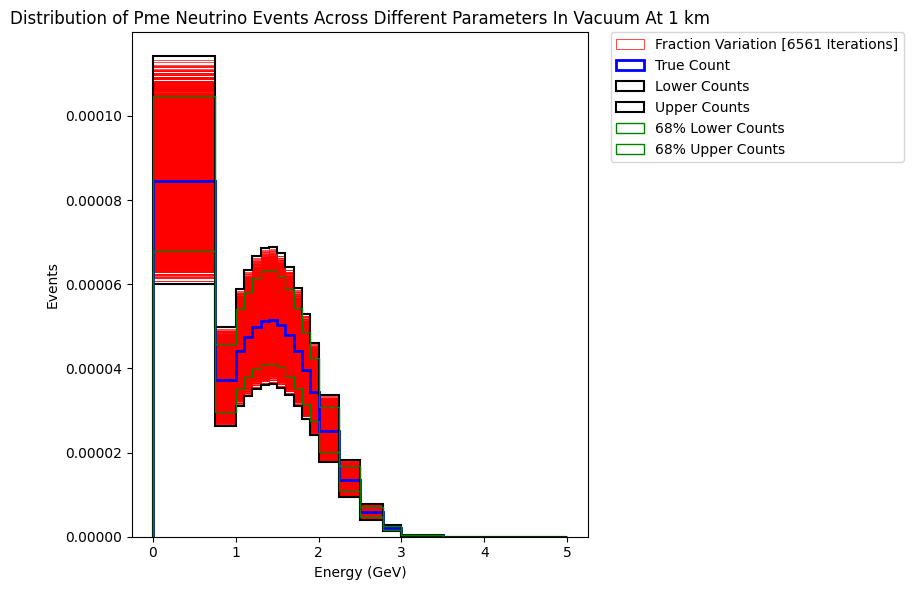

Highest count: 0.0008430121309686441 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 0.00044342785895369114 at fraction: (-1, -1, 1, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.4243359924128742', 'Dm2_32=0.0023399999999999996']


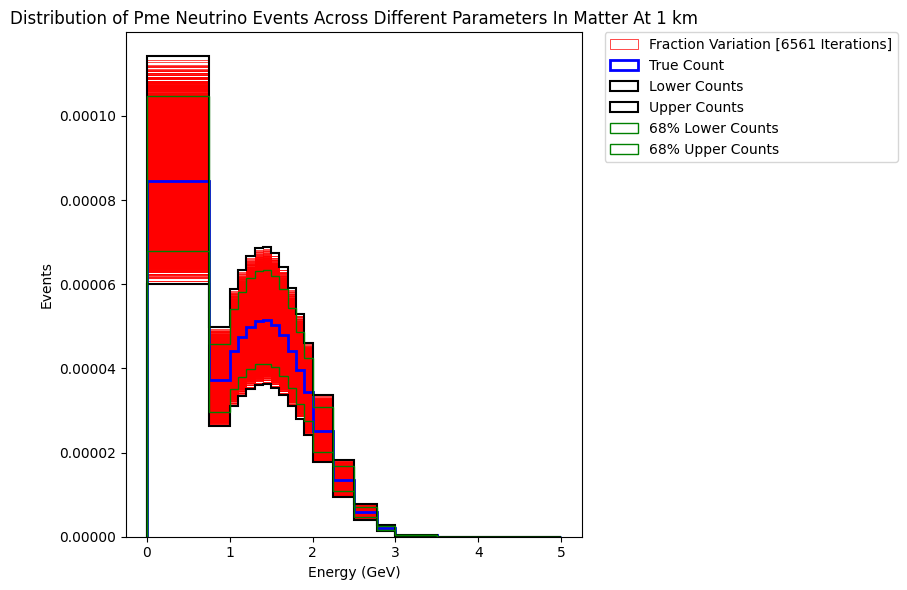

In [19]:
counts_nu_vac_nd, err_nu_vac_nd = osc_prob_3nu('neutrino', 'vacuum', length_nd, 'Pme', fractions)
counts_nu_mat_nd, err_nu_mat_nd = osc_prob_3nu('neutrino', 'matter', length_nd, 'Pme', fractions)

Highest count: 54.2110183271043 at fraction: (-0.5, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7416198487095662', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 31.612610552272443 at fraction: (-1, -1, 0.25, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=2.788163480060941', 'Dm2_32=0.0023399999999999996']


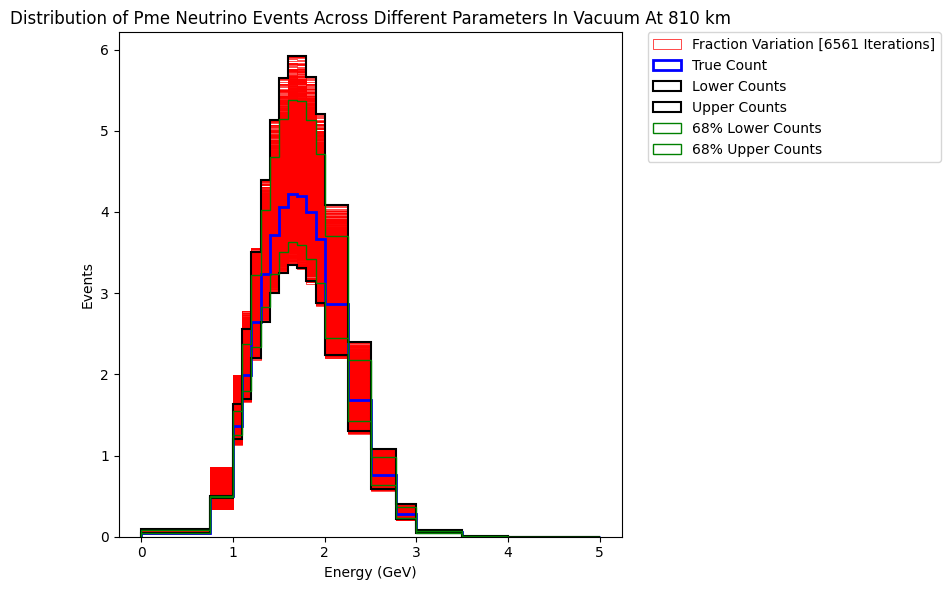

Highest count: 66.87042412273442 at fraction: (0, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 39.362291540254816 at fraction: (-1, -1, 0.25, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=2.788163480060941', 'Dm2_32=0.0023399999999999996']


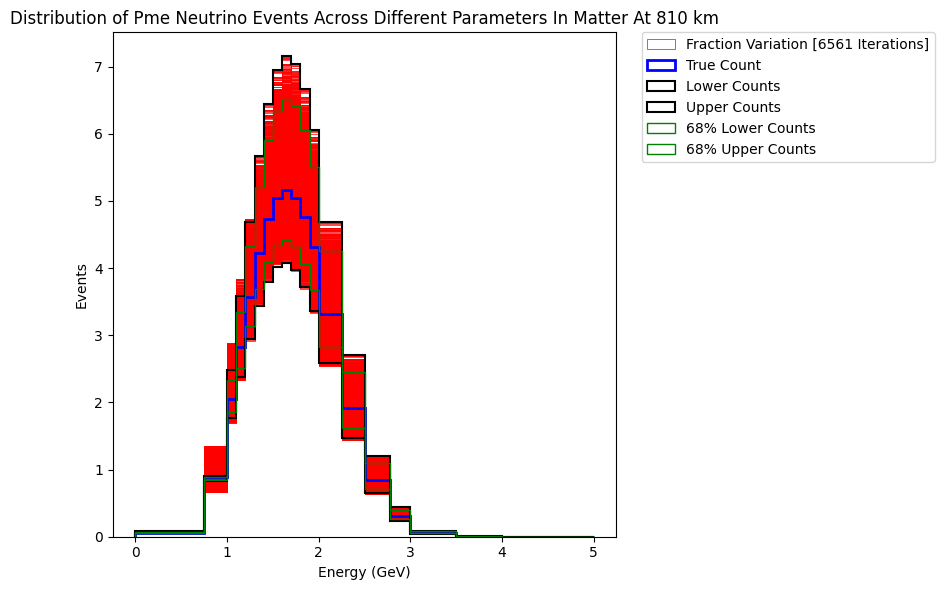

In [20]:
counts_nu_vac_fd, err_nu_vac_fd = osc_prob_3nu('neutrino', 'vacuum', length_fd, 'Pme', fractions)
counts_nu_mat_fd, err_nu_mat_fd = osc_prob_3nu('neutrino', 'matter', length_fd, 'Pme', fractions)

Highest count: 0.0005124806002134433 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 0.0002403121970782702 at fraction: (-1, -1, 1, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.4243359924128742', 'Dm2_32=0.0023399999999999996']


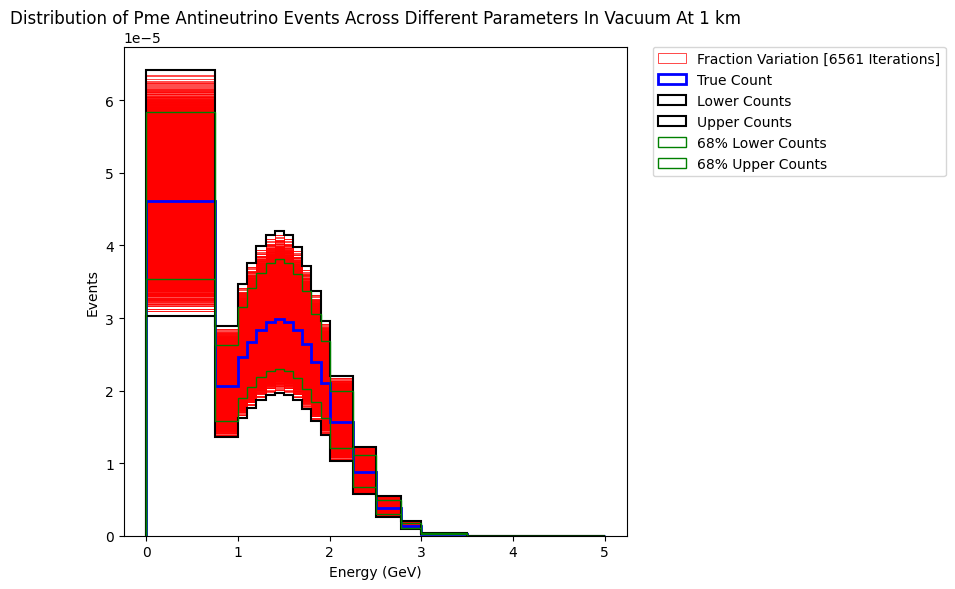

Highest count: 0.0005124791196373162 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 0.00024031145940852934 at fraction: (-1, -1, 1, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.4243359924128742', 'Dm2_32=0.0023399999999999996']


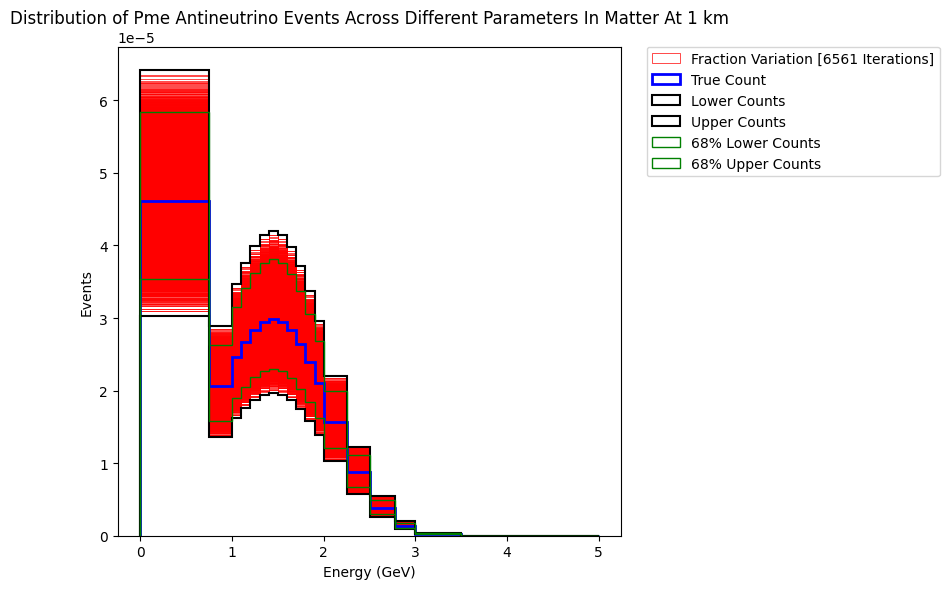

In [21]:
counts_nubar_vac_nd, err_nubar_vac_nd = osc_prob_3nu_bar('antineutrino', 'vacuum', length_nd, 'Pme', fractions)
counts_nubar_mat_nd, err_nubar_mat_nd = osc_prob_3nu_bar('antineutrino', 'matter', length_nd, 'Pme', fractions)

Highest count: 36.2108496838174 at fraction: (-1, 1, -0.25, 1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14866068747318506', 'd_cp=1.8928095737878499', 'Dm2_32=0.00248']
Lowest count: 19.76810980627398 at fraction: (1, -1, 1, -1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14106735979665885', 'd_cp=3.4243359924128742', 'Dm2_32=0.0023399999999999996']


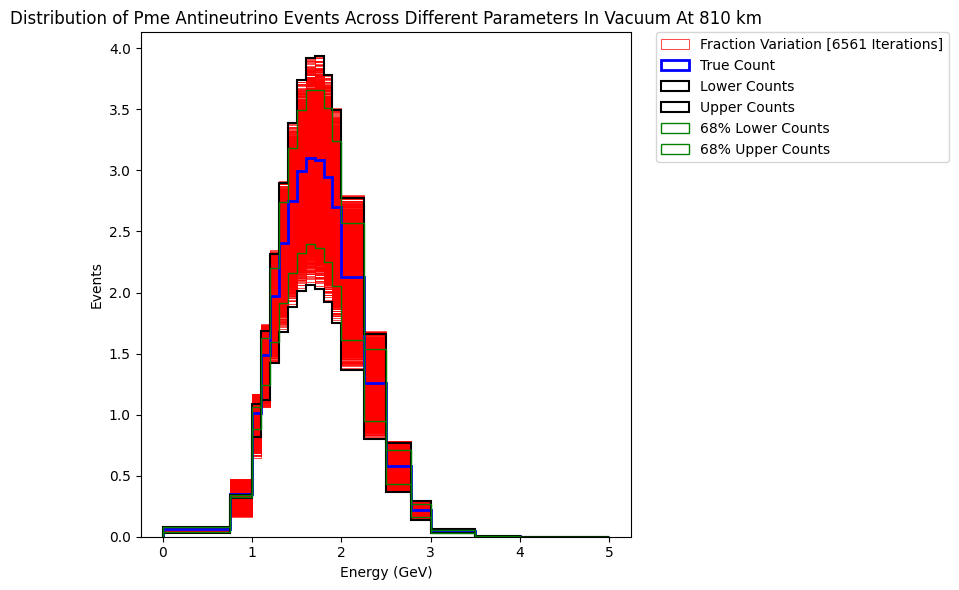

Highest count: 28.118659511827403 at fraction: (-1, 1, -0.25, 1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14866068747318506', 'd_cp=1.8928095737878499', 'Dm2_32=0.00248']
Lowest count: 15.292143292525761 at fraction: (1, -1, 1, -1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14106735979665885', 'd_cp=3.4243359924128742', 'Dm2_32=0.0023399999999999996']


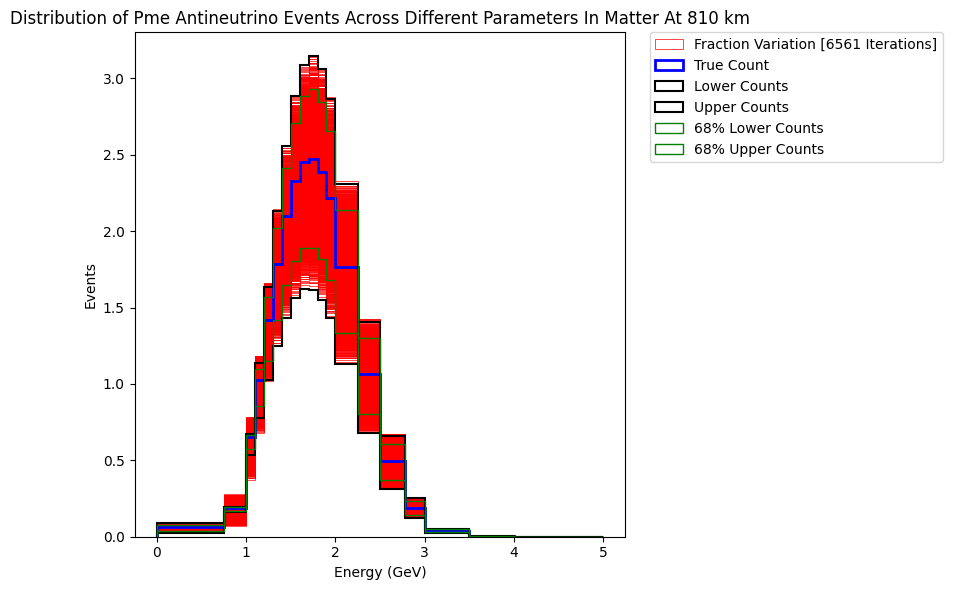

In [22]:
counts_nubar_vac_fd, err_nubar_vac_fd = osc_prob_3nu_bar('antineutrino', 'vacuum', length_fd, 'Pme', fractions)
counts_nubar_mat_fd, err_nubar_mat_fd = osc_prob_3nu_bar('antineutrino', 'matter', length_fd, 'Pme', fractions)

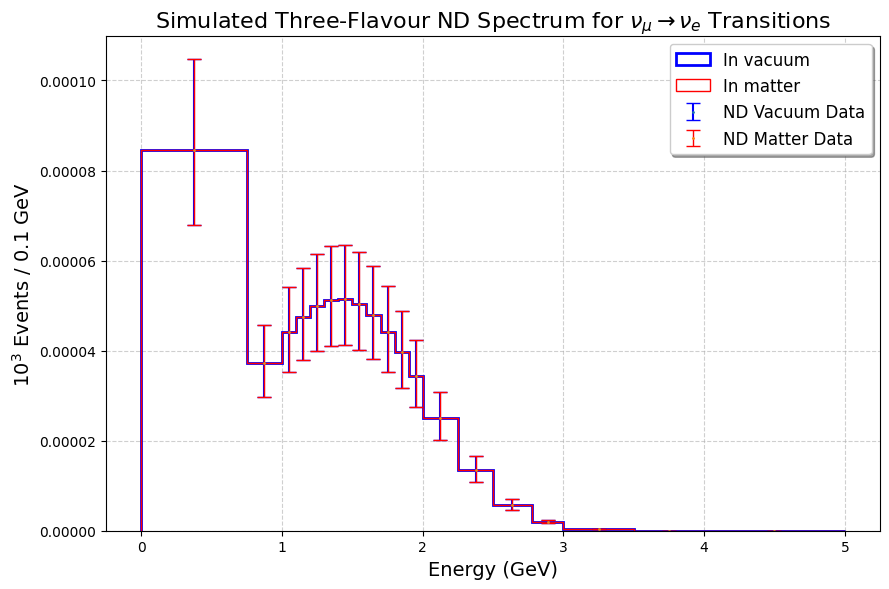

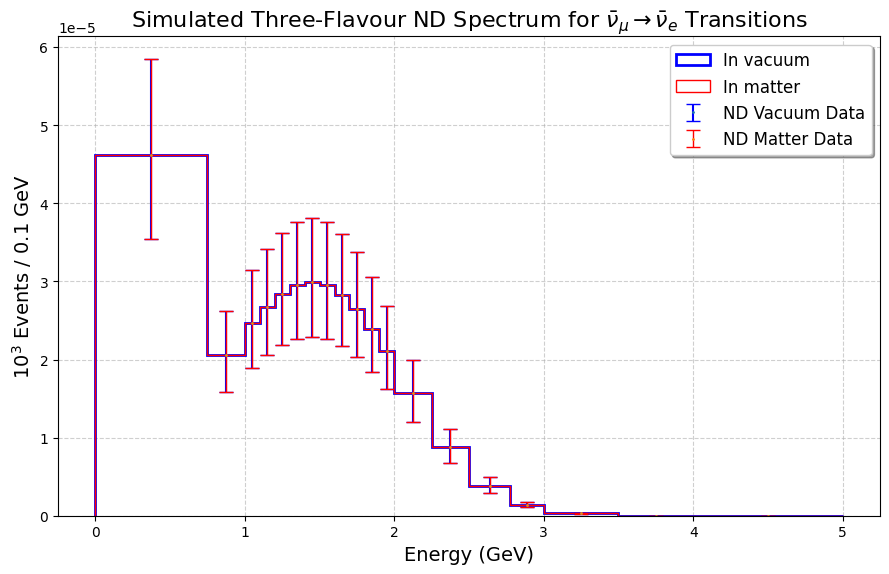

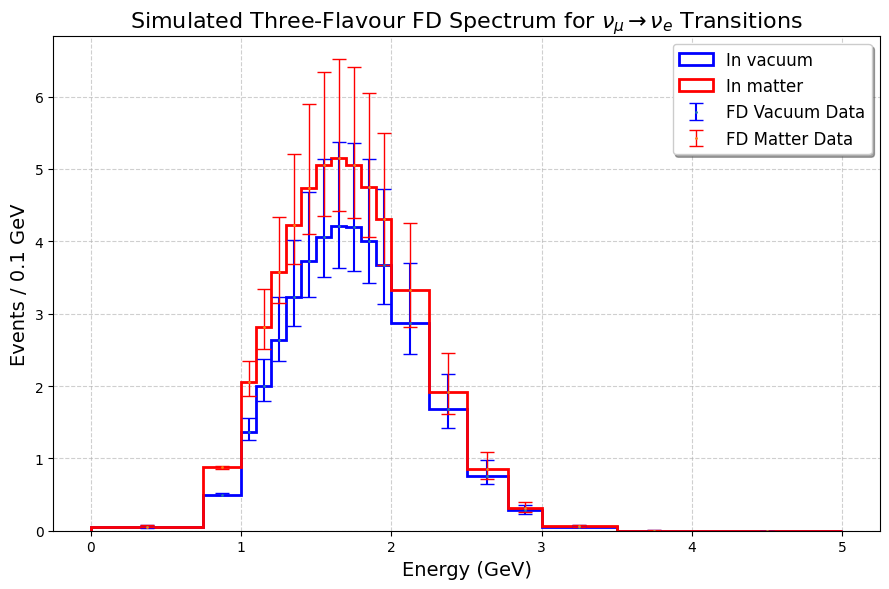

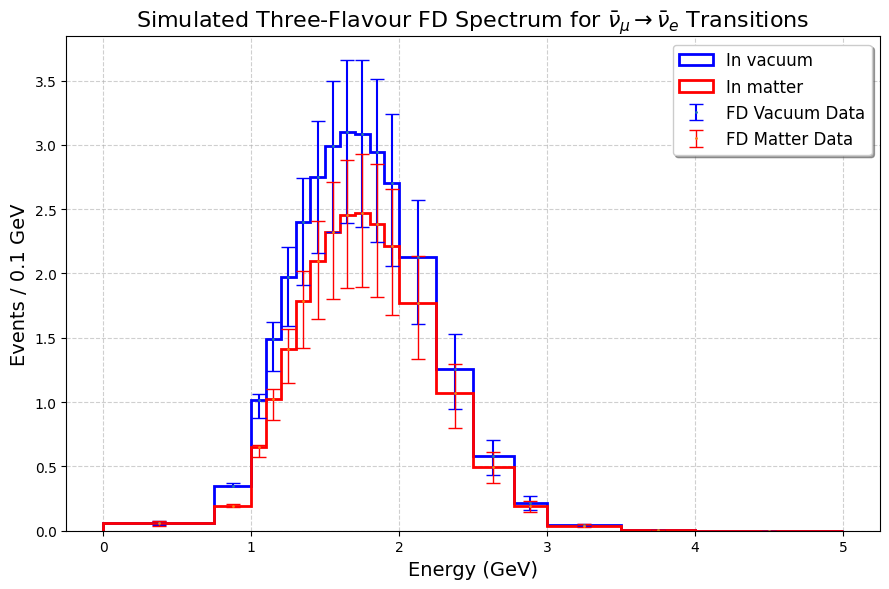

In [23]:
plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts_nu_vac_nd, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts_nu_mat_nd, histtype='step', label=r'In matter', linewidth=1, color='red')
plt.errorbar(bin_centers, counts_nu_vac_nd, yerr=err_nu_vac_nd, label='ND Vacuum Data', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
plt.errorbar(bin_centers, counts_nu_mat_nd, yerr=err_nu_mat_nd, label='ND Matter Data', fmt='o', capsize=5, ecolor='red', elinewidth=1, markersize=1, markerfacecolor='black')
title = r'Simulated Three-Flavour ND Spectrum for $\nu _\mu \,\to\, \nu _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel(r'$10^3$ Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts_nubar_vac_nd, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts_nubar_mat_nd, histtype='step', label=r'In matter', linewidth=1, color='red')
plt.errorbar(bin_centers, counts_nubar_vac_nd, yerr=err_nubar_vac_nd, label='ND Vacuum Data', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
plt.errorbar(bin_centers, counts_nubar_mat_nd, yerr=err_nubar_mat_nd, label='ND Matter Data', fmt='o', capsize=5, ecolor='red', elinewidth=1, markersize=1, markerfacecolor='black')
title = r'Simulated Three-Flavour ND Spectrum for $\bar{\nu} _\mu \,\to\, \bar{\nu} _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel(r'$10^3$ Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts_nu_vac_fd, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts_nu_mat_fd, histtype='step', label=r'In matter', linewidth=2, color='red')
plt.errorbar(bin_centers, counts_nu_vac_fd, yerr=err_nu_vac_fd, label='FD Vacuum Data', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
plt.errorbar(bin_centers, counts_nu_mat_fd, yerr=err_nu_mat_fd, label='FD Matter Data', fmt='o', capsize=5, ecolor='red', elinewidth=1, markersize=1, markerfacecolor='black')
title = r'Simulated Three-Flavour FD Spectrum for $\nu _\mu \,\to\, \nu _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts_nubar_vac_fd, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts_nubar_mat_fd, histtype='step', label=r'In matter', linewidth=2, color='red')
plt.errorbar(bin_centers, counts_nubar_vac_fd, yerr=err_nubar_vac_fd, label='FD Vacuum Data', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
plt.errorbar(bin_centers, counts_nubar_mat_fd, yerr=err_nubar_mat_fd, label='FD Matter Data', fmt='o', capsize=5, ecolor='red', elinewidth=1, markersize=1, markerfacecolor='black')
title = r'Simulated Three-Flavour FD Spectrum for $\bar{\nu} _\mu \,\to\, \bar{\nu} _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()